In [31]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime, timedelta
import time
import re
import matplotlib.pyplot as plt



In [34]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
#TimeOutException
from selenium.common.exceptions import TimeoutException


First, we calculate the EPU non-newspaper-specific. The used EPU is calculated below

In [5]:

# Function to generate months between two dates
def generate_monthly_ranges(start_year=1913, end_year=1940):
    date_ranges = []
    current_date = datetime(start_year, 1, 1)
    end_date = datetime(end_year, 12, 31)
    
    while current_date <= end_date:
        start_date = current_date.strftime("%Y-%m-%d")
        last_day = (current_date.replace(day=28) + timedelta(days=4)).replace(day=1) - timedelta(days=1)
        end_date_str = last_day.strftime("%Y-%m-%d")
        date_ranges.append((start_date, end_date_str))
        
        # Move to next month
        current_date = last_day + timedelta(days=1)
    
    return date_ranges


def build_driver():
    chrome_options = Options()
    chrome_options.add_argument("--headless")       # run in headless mode
    chrome_options.add_argument("--disable-gpu")
    chrome_options.add_argument("--no-sandbox")

    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=chrome_options)
    return driver

def scrape_anno():
    BASE_URL = (
        "https://anno.onb.ac.at/anno-suche/complex?"
        "text=Wirtschaft;wirtschaftlich;Unternehmen;Industrie;Zentralbank;Geldpolitik;"
        "Kronen;Schilling;Banksatz;Inflation;Budget;Defizit;Haushaltsdefizit;Schulden;"
        "Kredit;Zoll;Wirtschaftspolitik;Politik;Regulierung;Gesetz;Steuer;Reparationen;"
        "Reparationszahlungen;Krieg;unsicher;Unsicherheit;Unsicherheiten"
        "&language=ger&dateMode=date"
        "&dateFrom={start_date}&dateTo={end_date}&from=1"
    )

    # Prepare Selenium driver
    driver = build_driver()
    wait = WebDriverWait(driver, 20)  # up to 20s wait for elements
    
    # Date ranges
    monthly_ranges = generate_monthly_ranges(1913, 1940) 

    results = []
    
    for (start_date, end_date) in monthly_ranges:
        url = BASE_URL.format(start_date=start_date, end_date=end_date)
        driver.get(url)
        
        # Wait until the <h3 class="flex-grow-1"> appears (it should contain "xx Ergebnisse")
        try:
            h3_element = wait.until(
                EC.visibility_of_element_located((By.CSS_SELECTOR, "h3.flex-grow-1"))
            )
            text = h3_element.text.strip()  # e.g. "94 Ergebnisse"
            
            digits = re.findall(r"\d+", text)
            if digits:
                joined = "".join(digits)
                num_results = int(joined)
            else: 
                num_results = 0
            
        except Exception as e:
            # if anything goes wrong (element not found, etc.)
            print(f"Failed to get results for {start_date} to {end_date}:", e)
            num_results = 0

        results.append((start_date, end_date, num_results))
        print(f"{start_date} to {end_date}: {num_results} Ergebnisse")

    driver.quit()  # close browser
    return results



In [6]:
if __name__ == '__main__':
    data = scrape_anno()

    df = pd.DataFrame(data, columns=['Start Date', 'End Date', 'Num Results'])
    df.to_csv("anno_search_results.csv", index=False)
    print("\nScraping finished. Results saved to anno_search_results.csv")

1900-01-01 to 1900-01-31: 101 Ergebnisse
1900-02-01 to 1900-02-28: 104 Ergebnisse
1900-03-01 to 1900-03-31: 126 Ergebnisse
1900-04-01 to 1900-04-30: 120 Ergebnisse
1900-05-01 to 1900-05-31: 133 Ergebnisse
1900-06-01 to 1900-06-30: 146 Ergebnisse
1900-07-01 to 1900-07-31: 98 Ergebnisse
1900-08-01 to 1900-08-31: 111 Ergebnisse
1900-09-01 to 1900-09-30: 137 Ergebnisse
1900-10-01 to 1900-10-31: 133 Ergebnisse
1900-11-01 to 1900-11-30: 137 Ergebnisse
1900-12-01 to 1900-12-31: 132 Ergebnisse
1901-01-01 to 1901-01-31: 143 Ergebnisse
1901-02-01 to 1901-02-28: 132 Ergebnisse
1901-03-01 to 1901-03-31: 146 Ergebnisse
1901-04-01 to 1901-04-30: 136 Ergebnisse
1901-05-01 to 1901-05-31: 147 Ergebnisse
1901-06-01 to 1901-06-30: 150 Ergebnisse
1901-07-01 to 1901-07-31: 155 Ergebnisse
1901-08-01 to 1901-08-31: 141 Ergebnisse
1901-09-01 to 1901-09-30: 117 Ergebnisse
1901-10-01 to 1901-10-31: 151 Ergebnisse
1901-11-01 to 1901-11-30: 169 Ergebnisse
1901-12-01 to 1901-12-31: 140 Ergebnisse
1902-01-01 to 190

In [22]:
# --------------------------------------------------------------------------
# 3. Main scraping function to find total articles
# --------------------------------------------------------------------------
def scrape_anno_total():
    # Base URL *without* any text query. 
    # Just the language param, date mode, date range, & start=1:
    BASE_URL = (
        "https://anno.onb.ac.at/anno-suche/complex?"
        "language=ger&dateMode=date&dateFrom={start_date}&dateTo={end_date}&from=1"
    )

    # Build Selenium driver
    driver = build_driver()
    wait = WebDriverWait(driver, 20)

    monthly_ranges = generate_monthly_ranges(1913, 1940)

    results = []

    for (start_date, end_date) in monthly_ranges:
        url = BASE_URL.format(start_date=start_date, end_date=end_date)
        driver.get(url)

        num_articles = 0
        # Wait until we find h3.flex-grow-1, e.g. "12345 Ergebnisse"
        try:
            
            h3_element = wait.until(
                EC.visibility_of_element_located((By.CSS_SELECTOR, "h3.flex-grow-1"))
            )
            text = h3_element.text.strip()
            
            digits = re.findall(r"\d+", text)
            if digits:
                joined = "".join(digits)
                num_articles = int(joined)
            else: 
                num_articles = 0

        except Exception as e:
            print(f"Error retrieving {start_date} - {end_date}:", e)

        results.append((start_date, end_date, num_articles))
        print(f"{start_date} to {end_date}: {num_articles} total articles")

    driver.quit()
    return results


In [29]:
if __name__ == "__main__":
    datatotal = scrape_anno_total()
    dftotal = pd.DataFrame(datatotal, columns=["Start Date", "End Date", "Num Articles"])
    dftotal.to_csv("anno_total_articles_1913_1940.csv", index=False)
    print("\nScraping done. Saved to anno_total_articles_1913_1940.csv")
    

1900-01-01 to 1900-01-31: 1250 total articles
1900-02-01 to 1900-02-28: 1194 total articles
1900-03-01 to 1900-03-31: 1367 total articles
1900-04-01 to 1900-04-30: 1300 total articles
1900-05-01 to 1900-05-31: 1423 total articles
1900-06-01 to 1900-06-30: 1372 total articles
1900-07-01 to 1900-07-31: 1419 total articles
1900-08-01 to 1900-08-31: 1434 total articles
1900-09-01 to 1900-09-30: 1387 total articles
1900-10-01 to 1900-10-31: 1398 total articles
1900-11-01 to 1900-11-30: 1356 total articles
1900-12-01 to 1900-12-31: 1325 total articles
1901-01-01 to 1901-01-31: 1381 total articles
1901-02-01 to 1901-02-28: 1242 total articles
1901-03-01 to 1901-03-31: 1378 total articles
1901-04-01 to 1901-04-30: 1306 total articles
1901-05-01 to 1901-05-31: 1421 total articles
1901-06-01 to 1901-06-30: 1442 total articles
1901-07-01 to 1901-07-31: 1494 total articles
1901-08-01 to 1901-08-31: 1507 total articles
1901-09-01 to 1901-09-30: 1418 total articles
1901-10-01 to 1901-10-31: 1429 tot

In [30]:
#Combine df and dftotal into a new dataframe
df_combined = pd.concat([df, dftotal], axis=1)
df_combined.to_csv("anno_search_results_combined.csv", index=False)


In the code below, we webscrape the EPU for the 6 newspapers specified.

In [37]:
# Newspapers: user-friendly name -> URL-encoded title
NEWSPAPERS = {
    "Neues Wiener Journal": "Neues%20Wiener%20Journal",
    "Reichspost": "Reichspost",
    "Wiener Zeitung": "Wiener%20Zeitung",
    "Neue Freie Presse": "Neue%20Freie%20Presse",
    "Neues Wiener Tagblatt (Tages-Ausgabe)": "Neues%20Wiener%20Tagblatt%20%28Tages-Ausgabe%29",
    "Illustrierte Kronen-Zeitung": "Illustrierte%20Kronen-Zeitung"
}

# Keywords in one big semicolon-separated string (URL-encoded)
KEYWORDS = (
    "Wirtschaft;%20wirtschaftlich;%20Unternehmen;%20Industrie;%20Zentralbank;%20Geldpolitik;"
    "Kronen;%20Schilling;%20Banksatz;%20Inflation;%20Budget;%20Defizit;%20Haushaltsdefizit;"
    "Schulden;%20Kredit;%20Zoll;%20Wirtschaftspolitik;%20Politik;%20Regulierung;%20Gesetz;"
    "Steuer;%20Reparationen;%20Reparationszahlungen;%20Krieg;%20unsicher;%20Unsicherheit;"
    "Unsicherheiten"
)

# --------------------------------------------------------------------------
# 1. Generate monthly date ranges
# --------------------------------------------------------------------------
def generate_monthly_ranges(start_year=1900, end_year=1940):
    """
    Adjust start_year/end_year as needed.
    For a single year, pass the same start/end. 
    For multiple years, e.g., generate_monthly_ranges(1900, 1940).
    """
    date_ranges = []
    current_date = datetime(start_year, 1, 1)
    last_date = datetime(end_year, 12, 31)

    while current_date <= last_date:
        start_str = current_date.strftime("%Y-%m-%d")
        # End of the current month
        month_end = (current_date.replace(day=28) + timedelta(days=4))
        month_end = month_end.replace(day=1) - timedelta(days=1)
        end_str = month_end.strftime("%Y-%m-%d")
        date_ranges.append((start_str, end_str))
        current_date = month_end + timedelta(days=1)

    return date_ranges

# --------------------------------------------------------------------------
# 2. Build the Selenium driver
# --------------------------------------------------------------------------
def build_driver():
    chrome_options = Options()
    chrome_options.add_argument("--headless")  # run headless so no browser opens
    chrome_options.add_argument("--disable-gpu")
    chrome_options.add_argument("--no-sandbox")
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=chrome_options)
    return driver

# --------------------------------------------------------------------------
# 3. Scrape function
# --------------------------------------------------------------------------
def scrape_articles_by_newspaper(start_year=1913, end_year=1940):
    """
    For each month from start_year to end_year,
    for each newspaper in NEWSPAPERS,
    fetch number of articles with the given KEYWORDS.
    Returns a list of dicts, each representing one row (month) with columns for each newspaper.
    """
    driver = build_driver()
    wait = WebDriverWait(driver, 20)  # wait up to 20s for page to load
    
    # Prepare all monthly ranges
    monthly_ranges = generate_monthly_ranges(start_year, end_year)

    results = []  # each entry is a dict: {"Start Date": ..., "End Date": ..., "Neues Wiener Journal": 12, ...}

    for (start_date, end_date) in monthly_ranges:
        # We'll build one row for this month, plus the columns for each newspaper
        row_data = {
            "Start Date": start_date,
            "End Date": end_date
        }

        for newspaper_name, newspaper_url_title in NEWSPAPERS.items():
            # Construct the search URL
            # Notice we add "&title=..." for the newspaper
            # plus the KEYWORDS in the text=... parameter
            url = (
                "https://anno.onb.ac.at/anno-suche/complex?"
                f"text={KEYWORDS}"
                f"&title={newspaper_url_title}"
                f"&language=ger&dateMode=date"
                f"&dateFrom={start_date}&dateTo={end_date}&from=1"
            )

            driver.get(url)

            # Initialize article_count to 0 in case of error
            article_count = 0
            try:
                h3_element = wait.until(
                    EC.visibility_of_element_located((By.CSS_SELECTOR, "h3.flex-grow-1"))
                )
                raw_text = h3_element.text.strip()  # e.g. "1.078 Ergebnisse"

                # Extract digits ignoring punctuation like '.' or ','
                # e.g. "1.078" -> "1078"
                match = re.findall(r"\d+", raw_text)
                if match: 
                    joined = "".join(match)
                    article_count = int(joined)
                else:
                    article_count = 0
            except TimeoutException: # Probably no coverage for that date range/newspaper
                article_count = 0
                print(f"No coverage or no results for {newspaper_name}, {start_date}-{end_date}")

            # Store the result in the row
            row_data[newspaper_name] = article_count

        # Done with all newspapers for this month -> add to results
        results.append(row_data)
        print(f"Row for {start_date} - {end_date}: {row_data}")

    driver.quit()
    return results

In [38]:
if __name__ == "__main__":
    
    data = scrape_articles_by_newspaper(1913, 1940)

    # Convert to DataFrame
    df = pd.DataFrame(data)
    df.to_csv("anno_articles_by_newspaper.csv", index=False)
    print("\nDone. Results in anno_articles_by_newspaper.csv")

Row for 1913-01-01 - 1913-01-31: {'Start Date': '1913-01-01', 'End Date': '1913-01-31', 'Neues Wiener Journal': 15, 'Reichspost': 13, 'Wiener Zeitung': 23, 'Neue Freie Presse': 21, 'Neues Wiener Tagblatt (Tages-Ausgabe)': 24, 'Illustrierte Kronen-Zeitung': 2}
Row for 1913-02-01 - 1913-02-28: {'Start Date': '1913-02-01', 'End Date': '1913-02-28', 'Neues Wiener Journal': 10, 'Reichspost': 16, 'Wiener Zeitung': 26, 'Neue Freie Presse': 15, 'Neues Wiener Tagblatt (Tages-Ausgabe)': 24, 'Illustrierte Kronen-Zeitung': 2}
No coverage or no results for Illustrierte Kronen-Zeitung, 1913-03-01-1913-03-31
Row for 1913-03-01 - 1913-03-31: {'Start Date': '1913-03-01', 'End Date': '1913-03-31', 'Neues Wiener Journal': 8, 'Reichspost': 12, 'Wiener Zeitung': 20, 'Neue Freie Presse': 22, 'Neues Wiener Tagblatt (Tages-Ausgabe)': 23, 'Illustrierte Kronen-Zeitung': 0}
Row for 1913-04-01 - 1913-04-30: {'Start Date': '1913-04-01', 'End Date': '1913-04-30', 'Neues Wiener Journal': 11, 'Reichspost': 13, 'Wiene

Now, we calculate the overall number of articles for each newspaper

In [43]:
# Newspapers: user-friendly name -> URL-encoded title
NEWSPAPERS = {
    "Neues Wiener Journal": "Neues%20Wiener%20Journal",
    "Reichspost": "Reichspost",
    "Wiener Zeitung": "Wiener%20Zeitung",
    "Neue Freie Presse": "Neue%20Freie%20Presse",
    "Neues Wiener Tagblatt (Tages-Ausgabe)": "Neues%20Wiener%20Tagblatt%20%28Tages-Ausgabe%29",
    "Illustrierte Kronen-Zeitung": "Illustrierte%20Kronen-Zeitung"
}


# --------------------------------------------------------------------------
# 1. Generate monthly date ranges
# --------------------------------------------------------------------------
def generate_monthly_ranges(start_year=1913, end_year=1940):
    """
    Adjust start_year/end_year as needed.
    For a single year, pass the same start/end. 
    For multiple years, e.g., generate_monthly_ranges(1900, 1940).
    """
    date_ranges = []
    current_date = datetime(start_year, 1, 1)
    last_date = datetime(end_year, 12, 31)

    while current_date <= last_date:
        start_str = current_date.strftime("%Y-%m-%d")
        # End of the current month
        month_end = (current_date.replace(day=28) + timedelta(days=4))
        month_end = month_end.replace(day=1) - timedelta(days=1)
        end_str = month_end.strftime("%Y-%m-%d")
        date_ranges.append((start_str, end_str))
        current_date = month_end + timedelta(days=1)

    return date_ranges

# --------------------------------------------------------------------------
# 2. Build the Selenium driver
# --------------------------------------------------------------------------
def build_driver():
    chrome_options = Options()
    chrome_options.add_argument("--headless")  # run headless so no browser opens
    chrome_options.add_argument("--disable-gpu")
    chrome_options.add_argument("--no-sandbox")
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=chrome_options)
    return driver

# --------------------------------------------------------------------------
# 3. Scrape function
# --------------------------------------------------------------------------
def scrape_articles_by_newspaper(start_year=1913, end_year=1940):
    """
    For each month from start_year to end_year,
    for each newspaper in NEWSPAPERS,
    fetch number of articles with the given KEYWORDS.
    Returns a list of dicts, each representing one row (month) with columns for each newspaper.
    """
    driver = build_driver()
    wait = WebDriverWait(driver, 20)  # wait up to 20s for page to load
    
    # Prepare all monthly ranges
    monthly_ranges = generate_monthly_ranges(start_year, end_year)

    results = []  # each entry is a dict: {"Start Date": ..., "End Date": ..., "Neues Wiener Journal": 12, ...}

    for (start_date, end_date) in monthly_ranges:
        # We'll build one row for this month, plus the columns for each newspaper
        row_data = {
            "Start Date": start_date,
            "End Date": end_date
        }

        for newspaper_name, newspaper_url_title in NEWSPAPERS.items():
            # Construct the search URL
            # Notice we add "&title=..." for the newspaper
            # plus the KEYWORDS in the text=... parameter
            url = (
                "https://anno.onb.ac.at/anno-suche/complex?"
                f"&title={newspaper_url_title}"
                f"&language=ger&dateMode=date"
                f"&dateFrom={start_date}&dateTo={end_date}&from=1"
            )

            driver.get(url)

            # Initialize article_count to 0 in case of error
            article_count = 0
            try:
                h3_element = wait.until(
                    EC.visibility_of_element_located((By.CSS_SELECTOR, "h3.flex-grow-1"))
                )
                raw_text = h3_element.text.strip()  # e.g. "1.078 Ergebnisse"

                # Extract digits ignoring punctuation like '.' or ','
                # e.g. "1.078" -> "1078"
                match = re.findall(r"\d+", raw_text)
                if match: 
                    joined = "".join(match)
                    article_count = int(joined)
                else:
                    article_count = 0
            except TimeoutException: # Probably no coverage for that date range/newspaper
                article_count = 0
                print(f"No coverage or no results for {newspaper_name}, {start_date}-{end_date}")

            # Store the result in the row
            row_data[newspaper_name] = article_count

        # Done with all newspapers for this month -> add to results
        results.append(row_data)
        print(f"Row for {start_date} - {end_date}: {row_data}")

    driver.quit()
    return results

In [44]:
if __name__ == "__main__":
    
    datatotal = scrape_articles_by_newspaper(1913, 1940)

    # Convert to DataFrame
    dftotal = pd.DataFrame(datatotal)
    dftotal.to_csv("total_anno_articles_by_newspaper.csv", index=False)
    print("\nDone. Results in total_anno_articles_by_newspaper.csv")

Row for 1913-01-01 - 1913-01-31: {'Start Date': '1913-01-01', 'End Date': '1913-01-31', 'Neues Wiener Journal': 30, 'Reichspost': 30, 'Wiener Zeitung': 82, 'Neue Freie Presse': 30, 'Neues Wiener Tagblatt (Tages-Ausgabe)': 30, 'Illustrierte Kronen-Zeitung': 30}
Row for 1913-02-01 - 1913-02-28: {'Start Date': '1913-02-01', 'End Date': '1913-02-28', 'Neues Wiener Journal': 28, 'Reichspost': 28, 'Wiener Zeitung': 78, 'Neue Freie Presse': 28, 'Neues Wiener Tagblatt (Tages-Ausgabe)': 28, 'Illustrierte Kronen-Zeitung': 28}
Row for 1913-03-01 - 1913-03-31: {'Start Date': '1913-03-01', 'End Date': '1913-03-31', 'Neues Wiener Journal': 29, 'Reichspost': 29, 'Wiener Zeitung': 81, 'Neue Freie Presse': 29, 'Neues Wiener Tagblatt (Tages-Ausgabe)': 29, 'Illustrierte Kronen-Zeitung': 29}
Row for 1913-04-01 - 1913-04-30: {'Start Date': '1913-04-01', 'End Date': '1913-04-30', 'Neues Wiener Journal': 30, 'Reichspost': 30, 'Wiener Zeitung': 85, 'Neue Freie Presse': 30, 'Neues Wiener Tagblatt (Tages-Ausgab

In [58]:
# Rename the columns from the total dataset with a prefix
dftotal.columns = [f"Total {col}" for col in dftotal.columns]

In [83]:
# combine the two datasets
df_combined = pd.concat([df, dftotal], axis=1)


In [84]:
# remove the "Start Date" and "End Date" columns from the second dataset
df_combined = df_combined.drop(columns=["Total Start Date", "Total End Date"])
# remove data after 31/12/1937
df_combined = df_combined[df_combined["End Date"] <= "1937-12-31"]


Now we calculate the overall EPU

In [85]:
papers = [
    "Neues Wiener Journal",
    "Reichspost",
    "Wiener Zeitung",
    "Neue Freie Presse",
    "Neues Wiener Tagblatt (Tages-Ausgabe)",
    "Illustrierte Kronen-Zeitung"
]

# -----------------------------------------------------
# A) Create Ratio Columns: paper_ratio = paper / total_paper
# -----------------------------------------------------
for paper in papers:
    ratio_col = f"{paper}_ratio"
    total_col = f"Total {paper}"

    df_combined[ratio_col] = df_combined[paper] / df_combined[total_col]

# -----------------------------------------------------
# B) Compute Std Dev of Each Ratio Column
# -----------------------------------------------------
std_devs = {}
ratio_cols = []

for paper in papers:
    ratio_col = f"{paper}_ratio"
    ratio_cols.append(ratio_col)
    std_devs[paper] = df_combined[ratio_col].std()

# -----------------------------------------------------
# C) Standardize Each Ratio Column => paper_std = ratio / std
# -----------------------------------------------------
for paper in papers:
    ratio_col = f"{paper}_ratio"
    std_col = f"{paper}_std"
    df_combined[std_col] = df_combined[ratio_col] / std_devs[paper]

# -----------------------------------------------------
# D) Average Across Standardized Columns => Z_t
# -----------------------------------------------------
std_cols = [f"{paper}_std" for paper in papers]
df_combined["Zt"] = df_combined[std_cols].mean(axis=1)

# -----------------------------------------------------
# E) Compute Mean of Z_t => M, Then Final EPU
# -----------------------------------------------------
M = df_combined["Zt"].mean()
df_combined["EPU"] = df_combined["Zt"] * (100 / M)




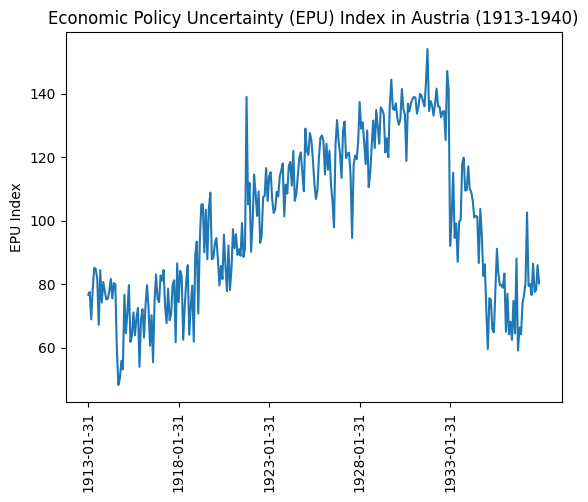

In [ ]:
# Plot the EPU with a 5 year ticks on the x axis showing only the year
plt.plot(df_combined["End Date"], df_combined["EPU"])
plt.title("Economic Policy Uncertainty (EPU) Index in Austria (1913-1937)")
plt.ylabel("EPU Index")
# for the ticks only show the year of end date
plt.xticks(df_combined["End Date"][::60], rotation=90)
plt.show()
